In [1]:
import dill
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import plotly.express as px
import plotly.graph_objs as go
print('done')
import csv


# USE_PLOTLY = False


done


In [2]:
def load_from_csv(input_string):
    with open(input_string, 'r') as fp:
        reader = csv.reader(fp)
        li = list(reader)
    newlist = []
    for row in li:
        newrow = []
        for entry in row [1:]:
            newrow.append(float(entry))
        newlist.append(newrow)
    return newlist


experiment_config_results = load_from_csv("experiment_config_results2.csv")

with open("experiments","rb") as current_file:
    experiments = dill.load(current_file)

    
non_unique_params = np.array([experiment['parameter'] for experiment in experiments])
non_unique_config_strings = np.array([experiment['config_string'] for experiment in experiments])

par_indices = np.unique(non_unique_params,return_index=True)[1]
string_indices = np.unique(non_unique_config_strings,return_index=True)[1]

parameters = non_unique_params[np.sort(par_indices)]
config_strings = non_unique_config_strings[np.sort(string_indices)]
# config_strings[0],config_strings[1],config_strings[2] = config_strings[2],config_strings[0],config_strings[1]
# config_strings[[0,1,2]] = config_strings[[2,0,1]]
print(config_strings)

def str_noneguard(obj):
    if hasattr(obj,'__name__'):
        return obj.__name__
    if obj is None:
        return ''
    if isinstance(obj,list):
        return str([str_noneguard(x) for x in obj])
    return str(obj)


print(len(config_strings))
# colors=['#4285F4','#EA4335', '#FBBC04',  '#34A853','#000000','#46BDC6',      '#46BDC6',             '#F4CCCC','#C9DAF8',            'grey','purple']
# red yellow !!!! !!!!! green teal ?? !!!!!!
# colors=['#EA4335', '#FBBC04', '#4285F4', '#000000','#34A853','#46BDC6',                  '#F4CCCC','purple',]
#        red         yellow      teal       black     green     blue      ??     purple
colors=['#EA4335', '#FBBC04', '#46BDC6', '#000000','#34A853','#4285F4', 'None',  'purple']
#         teal        red       black     yellow    purple     green       blue       ??
colors=['#46BDC6', '#EA4335', '#000000', '#FBBC04','#800080','#34A853', '#4285F4',  '#EEEEEE']
print(len(colors))
print(config_strings)
print("")
print("")

print(parameters)
print("")

# parameters[[3,4,5,6,7,8,9,10,11,12]] = parameters[[-4,-3,-2,5,3,4,6,8,-1,7]]
print(parameters)



['CCE, SD=4' 'JSD, SD=4' 'CCEu, SD=4' 'JSDu, SD=4' 'CCE, SD=100'
 'JSD, SD=100' 'JSDu, SD=100']
7
8
['CCE, SD=4' 'JSD, SD=4' 'CCEu, SD=4' 'JSDu, SD=4' 'CCE, SD=100'
 'JSD, SD=100' 'JSDu, SD=100']


['training_method' 'labeled_data_percentage' 'sampling_density'
 'activation_types' 'input_layer_type' 'encoding_dim' 'hidden_layers'
 'activity_regularizer' 'sigma' 'BN_size' 'gaussian_noise_sigma'
 'missing_entry' 'missing_entry_combined' 'missing_entry_no_denoising']

['training_method' 'labeled_data_percentage' 'sampling_density'
 'activation_types' 'input_layer_type' 'encoding_dim' 'hidden_layers'
 'activity_regularizer' 'sigma' 'BN_size' 'gaussian_noise_sigma'
 'missing_entry' 'missing_entry_combined' 'missing_entry_no_denoising']


In [34]:
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

def hex_to_rgb(hex_color: str) -> tuple:
    # thanks to https://community.plotly.com/t/scatter-plot-fill-with-color-how-to-set-opacity-of-fill/29591/2
    hex_color = hex_color.lstrip("#")
    if len(hex_color) == 3:
        hex_color = hex_color * 2
    return int(hex_color[0:2], 16), int(hex_color[2:4], 16), int(hex_color[4:6], 16)

def plot_vals(i,USE_PLOTLY,excluded_config_strings=[],ylim=[-175,100]):

    if USE_PLOTLY:
        fig = go.Figure()

    else:
        fig, ax = plt.subplots(figsize=[10,6])  
        

    parameter = parameters[i]
    bar=0
    all_numbers = True
    
    for config_index,config_string in enumerate(config_strings):
        color=colors[config_index]
    #     print("--------- " + config_string + " -----------")
        filtered_experiments = [ex for ex in experiments if ex['parameter']==parameter and ex['config_string']==config_string and config_string not in excluded_config_strings]
        if len(filtered_experiments)==0:
            continue
        mappings = np.array([x['mapping'] for x in filtered_experiments])
        x_values = [x['current_var'] for x in filtered_experiments]
        for x in x_values:
            if not isinstance(x,int) and not isinstance(x,float):
                all_numbers=False

        if not all_numbers:
            for i in range(len(x_values)):
                x_values[i] = str_noneguard(x_values[i])

        results = [result for result in np.array(experiment_config_results,dtype=object)[mappings] ]
        means = np.array([np.mean(x) for x in results])
        sigmas = np.array([np.std(x) for x in results])

        config_string=config_string.replace('SD=4', 'categorical')
        config_string=config_string.replace('SD=100', 'continuous')
        config_string=config_string.replace('CCE', 'Log loss')
        config_string=config_string.replace('JSD', 'JSD loss')
        config_string=config_string.replace('loss,', 'loss (semi-supervised),')
        config_string=config_string.replace('u,', ' (unsupervised),')

        if parameter=="training_method":
            config_string=config_string.replace(' (semi-supervised),', ',')
        if parameter=="sampling_density":
            config_string=config_string.replace(', categorical', '')
    #     print("mappings")
    #     display(mappings)
    #     print("")
    #     print("results")
    #     display(results)
    #     print("")
    #     print("x_values")
    #     display(x_values)
    #     print("")
    #     print("means")
    #     display(means)
    #     print("")
    #     print("sigmas")
    #     display(sigmas)
    #     print("\n\n\n")
    #     ax.plot(x_values,means)
#         print(x_values)
        if USE_PLOTLY:
            if all_numbers:
                # fig.add_trace(go.Scatter(x=x_values, y=means, error_y={"array":sigmas}, marker_color=color,name=config_string,mode='lines+markers'))
                fig.add_trace(go.Scatter(x=x_values, y=means, marker_color=color,name=config_string,mode='lines+markers'))
                fig.add_trace(go.Scatter(x=x_values, y=means+sigmas, marker_color=color,name="Upper bound", line=dict(width=0), showlegend=False, mode='lines'))
                fig.add_trace(go.Scatter(x=x_values, y=means-sigmas, marker_color=color,fillcolor=f"rgba{(*hex_to_rgb(color), 0.2)}",name="Lower bound", line=dict(width=0), showlegend=False, fill='tonexty', mode='lines'))
                
            else:
                fig.add_bar(x=x_values,y=means,error_y={"array":sigmas},marker_color=color,name=config_string)
        else:
            if all_numbers:
                ax.plot(x_values,means,'o-',label=config_string,color=color)
                ax.fill_between(x_values, (means-sigmas), (means+sigmas),alpha=.2,color=color)
            else:
                n=len(x_values)
                ind = np.arange(n)
                width = 0.1
                position = ind + (width*(1-n)/2) + bar*width
                ax.bar(position,means,width=width,yerr=sigmas,label=config_string,color=color)
                bar+=1
    
    if USE_PLOTLY:
        fig.update_yaxes(tick0=0, dtick=25)
        # fig.update_xaxes(tickangle = 0)
        fig.update_layout(yaxis_range=ylim,title=parameter, width=1000, height=600)
        fig.show()
    else:
        ax.set_ylim(ylim)
        
        if not all_numbers:
            print(x_values)
            print(ind)
    #         ax.axhline(0,"black")
            ax.yaxis.set_major_locator(MultipleLocator(25))    
            ax.grid(axis="y")
            
            plt.xticks(ind, x_values)
        else:
            ax.yaxis.set_major_locator(MultipleLocator(25))
            ax.grid()
        ax.axhline(0,color='black')
        ax.set_title(parameter)

        # plt.gca().set_axis_off()
        plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                    hspace = 0, wspace = 0)
        plt.margins(0,0)
        # plt.gca().xaxis.set_major_locator(plt.NullLocator())
        # plt.gca().yaxis.set_major_locator(plt.NullLocator())

        ax.legend()

['supervised', 'supervised_2_percent', 'semi', 'semi_sup_first', 'semi_mixed', 'unsupervised']
[0 1 2 3 4 5]
["['sin', 'cos', 'linear', 'relu', 'swish']", "['relu']", "['relu', 'relu', 'relu', 'relu', 'relu']", "['sin', 'cos', 'linear']", "['sin', 'cos', 'linear', 'relu', 'sigmoid']"]
[0 1 2 3 4]
['dense', 'gaussian_noise', 'gaussian_dropout', 'sqrt_softmax', 'gaussian_kernel', 'CNN', 'VAE']
[0 1 2 3 4 5 6]
['L2: 10^-4', 'L2: 0.01', 'L2: 10^-4', 'L1: 0.01', 'L1: 10^-4']
[0 1 2 3 4]
['lambda SD: 0.01', 'lambda SD: 0.02', 'lambda SD: 0.05', 'lambda SD: 0.1', 'lambda SD: 0.2', 'lambda SD: (0.01/SD)*100', 'lambda SD: (0.02/SD)*100', 'lambda SD: (0.05/SD)*100', 'lambda SD: (0.1/SD)*100', 'lambda SD: (0.2/SD)*100']
[0 1 2 3 4 5 6 7 8 9]


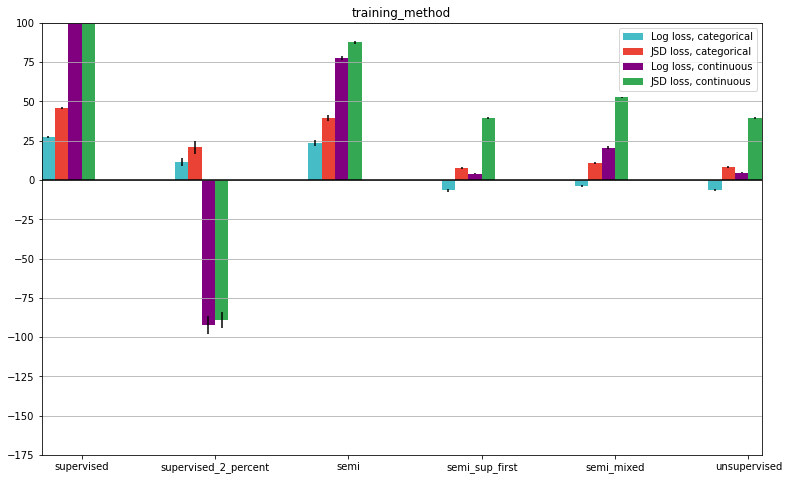

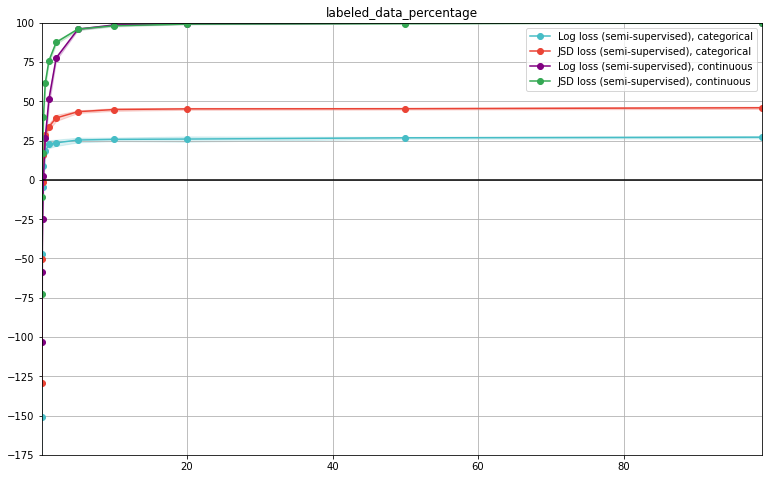

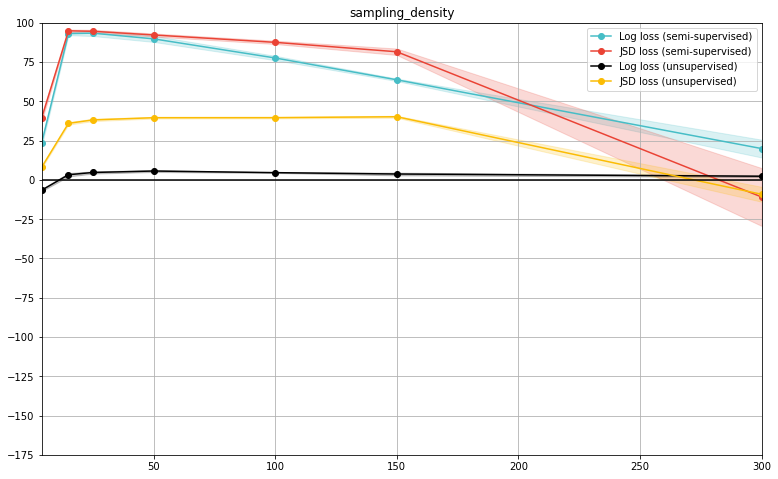

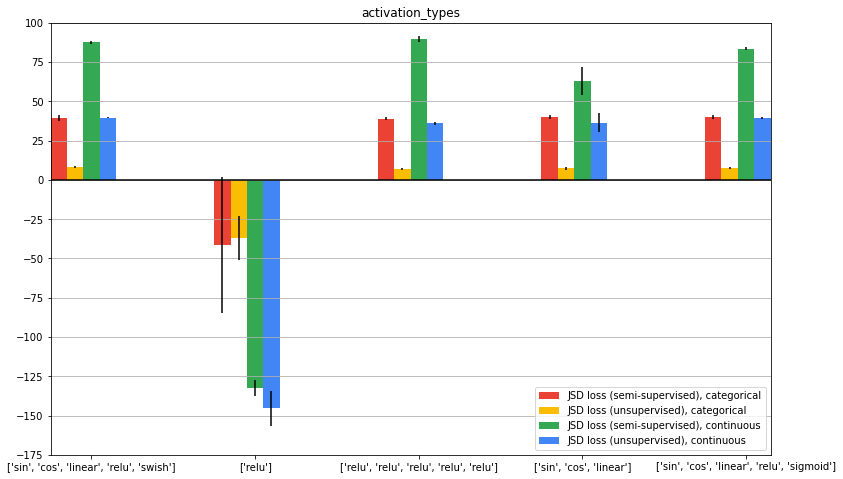

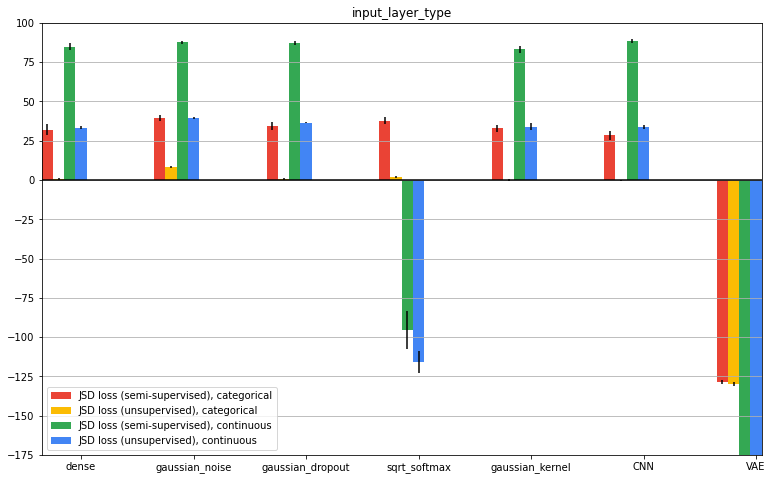

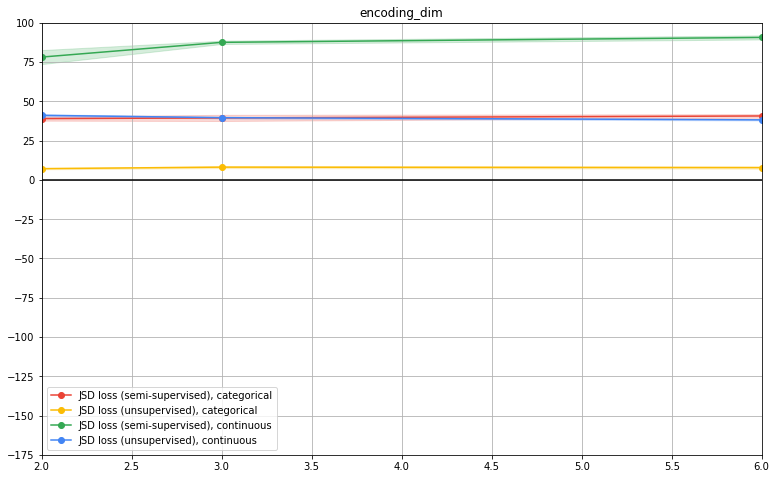

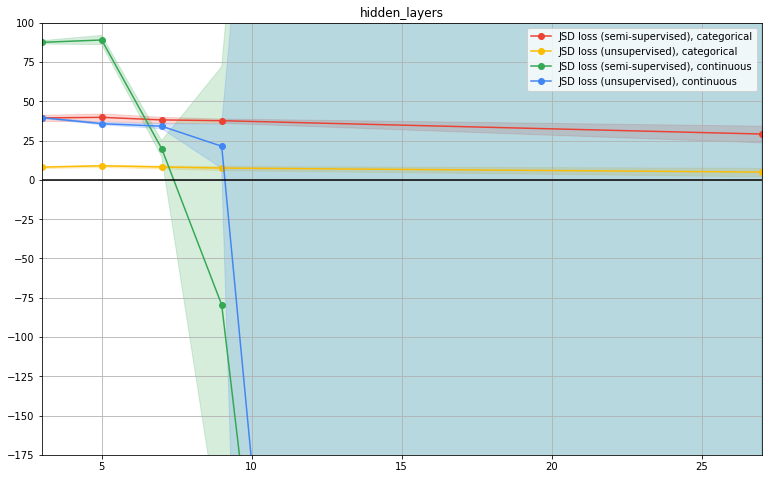

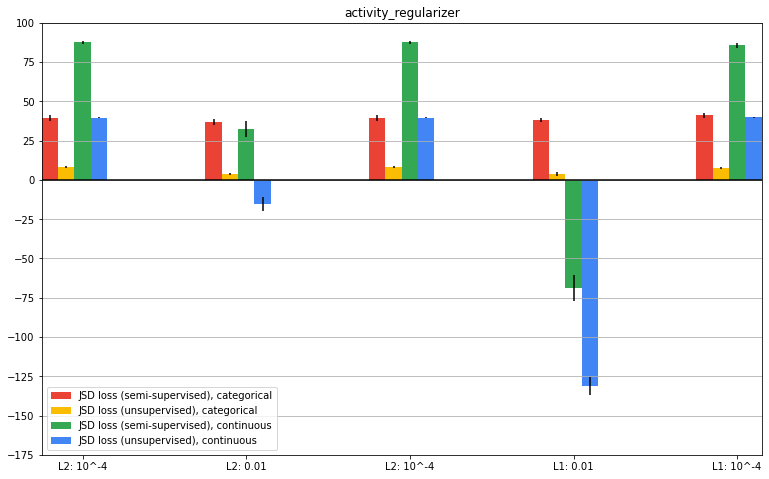

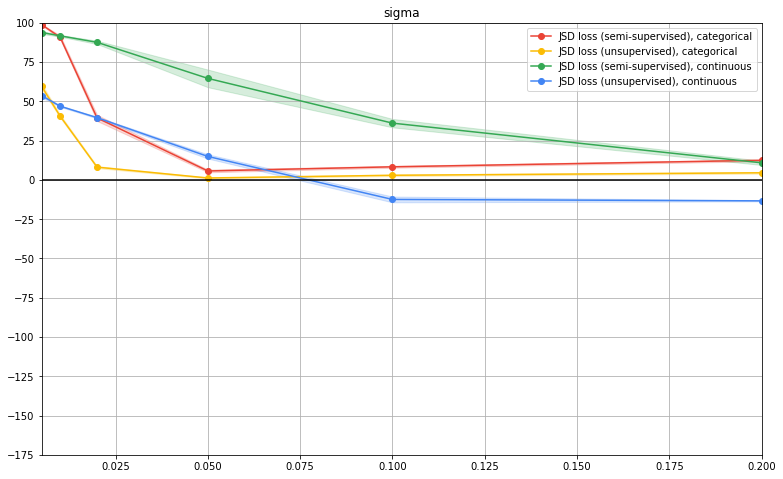

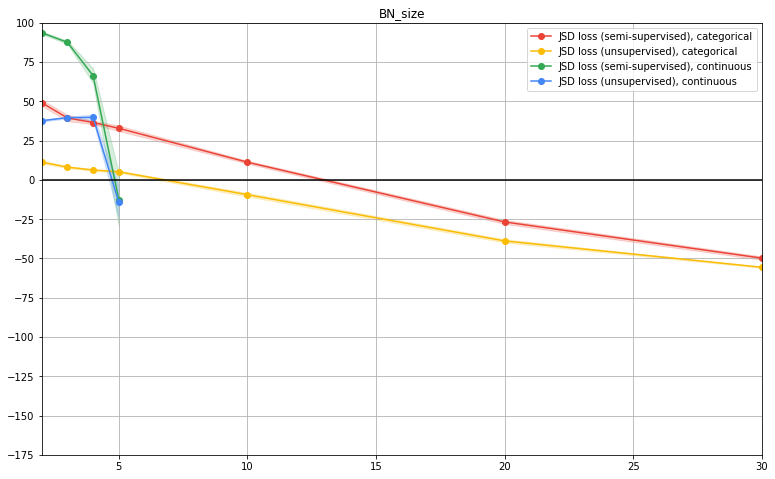

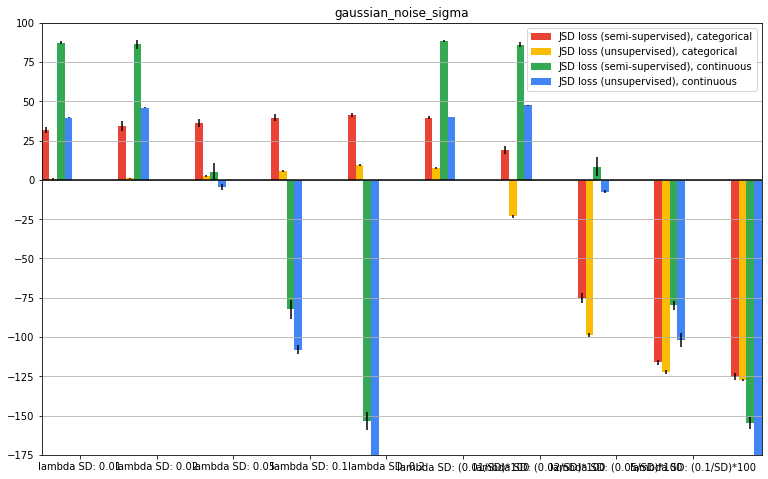

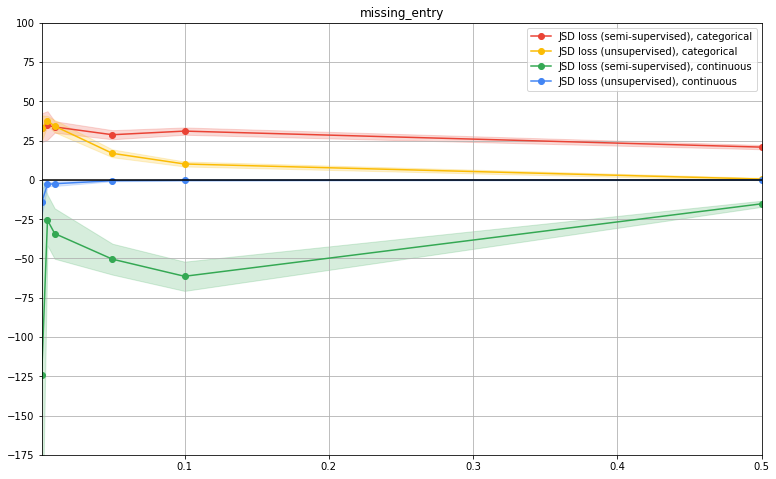

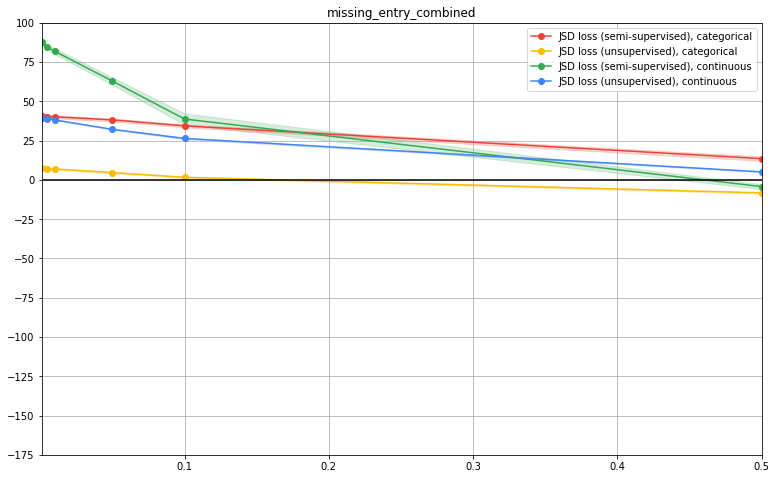

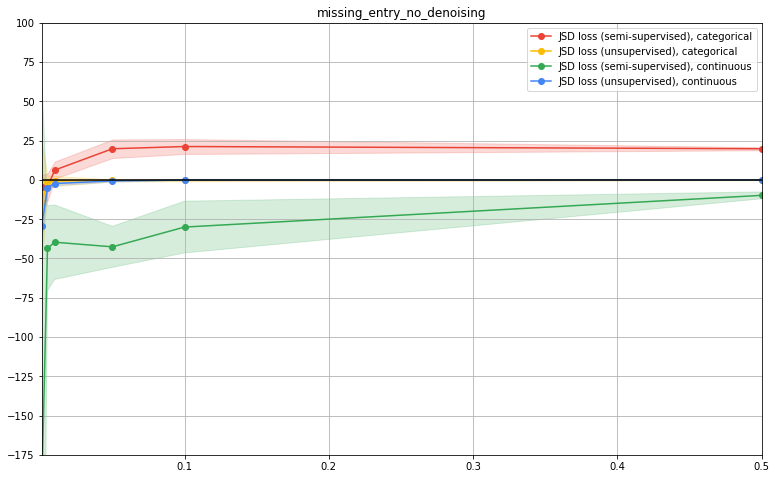

In [35]:
for i in range(len(parameters)):
    if i not in [0,1,2]:
        excluded_config_strings=['CCE, SD=4', 'CCEu, SD=4', 'CCE, SD=100','CCEu, SD=100']
    else:
        excluded_config_strings=[]
    plot_vals(i,USE_PLOTLY=False,excluded_config_strings=excluded_config_strings)
    plt.savefig("pictures/results_fig_"+ parameters[i] + ".svg", bbox_inches = 'tight',pad_inches = 0)

In [5]:
for i in range(len(parameters)):
    if i not in [0,1,2]:
        excluded_config_strings=['CCE, SD=4', 'CCEu, SD=4', 'CCE, SD=100','CCEu, SD=100']
    else:
        excluded_config_strings=[]
    plot_vals(i,USE_PLOTLY=True,excluded_config_strings=excluded_config_strings)

In [6]:
# a=[len(experiment_config_results[x['mapping']]) for i,x in enumerate(experiments)]
# unique, counts = np.unique(a, return_counts=True)
# dict(zip(unique, counts))


# [str(i) + ": " + x['full_string'] + " --- " +  str(len(experiment_config_results[x['mapping']])) for i,x in enumerate(experiments)]

[str(i) + ": " +  str(len(experiment_config_results[x['mapping']])) for i,x in enumerate(experiments)]

['0: 12',
 '1: 12',
 '2: 12',
 '3: 12',
 '4: 12',
 '5: 13',
 '6: 12',
 '7: 12',
 '8: 12',
 '9: 12',
 '10: 12',
 '11: 12',
 '12: 12',
 '13: 12',
 '14: 12',
 '15: 11',
 '16: 11',
 '17: 11',
 '18: 12',
 '19: 11',
 '20: 11',
 '21: 4',
 '22: 5',
 '23: 4',
 '24: 4',
 '25: 11',
 '26: 11',
 '27: 11',
 '28: 11',
 '29: 11',
 '30: 12',
 '31: 11',
 '32: 11',
 '33: 11',
 '34: 11',
 '35: 11',
 '36: 11',
 '37: 11',
 '38: 11',
 '39: 11',
 '40: 11',
 '41: 11',
 '42: 11',
 '43: 11',
 '44: 11',
 '45: 11',
 '46: 11',
 '47: 11',
 '48: 11',
 '49: 11',
 '50: 11',
 '51: 11',
 '52: 11',
 '53: 11',
 '54: 11',
 '55: 11',
 '56: 11',
 '57: 11',
 '58: 11',
 '59: 11',
 '60: 11',
 '61: 11',
 '62: 11',
 '63: 11',
 '64: 11',
 '65: 11',
 '66: 11',
 '67: 11',
 '68: 4',
 '69: 11',
 '70: 11',
 '71: 11',
 '72: 11',
 '73: 11',
 '74: 11',
 '75: 11',
 '76: 11',
 '77: 11',
 '78: 11',
 '79: 11',
 '80: 11',
 '81: 11',
 '82: 12',
 '83: 12',
 '84: 5',
 '85: 7',
 '86: 5',
 '87: 5',
 '88: 12',
 '89: 12',
 '90: 12',
 '91: 12',
 '92: 1